In [ ]:
import os.path
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import pyplot
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage import color
import skimage.filters
import skimage.viewer
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from natsort import natsorted, ns
import glob

In [ ]:
#test if we use GPU 
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
seed = 42
np.random.seed = seed
np.random.seed = seed

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 64
IMG_CHANNELS = 3

In [ ]:

TRAIN_PATH = "/content/drive/My Drive/Final/linux-Dataset/train/"
mask_Path = "/content/drive/My Drive/Final/linux-Dataset/train/"
TEST_PATH = "/content/drive/My Drive/Final/linux-Dataset/test_same/16/Fat/Axial/"

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[2]
mask_ids = next(os.walk(mask_Path))[1]
print(test_ids)

['image14.png', 'image12.png', 'image6.png', 'image7.png', 'image24.png', 'image3.png', 'image10.png', 'image13.png', 'image18.png', 'image16.png', 'image5.png', 'image15.png', 'image21.png', 'image1.png', 'image9.png', 'image8.png', 'image4.png', 'image17.png', 'image19.png', 'image25.png', 'image20.png', 'image22.png', 'image2.png', 'image11.png', 'image0.png', 'image23.png', 'image35.png', 'image34.png', 'image31.png', 'image27.png', 'image30.png', 'image38.png', 'image32.png', 'image29.png', 'image26.png', 'image37.png', 'image28.png', 'image33.png', 'image36.png', 'image55.png', 'image51.png', 'image50.png', 'image59.png', 'image52.png', 'image40.png', 'image45.png', 'image56.png', 'image53.png', 'image54.png', 'image42.png', 'image48.png', 'image44.png', 'image46.png', 'image61.png', 'image41.png', 'image60.png', 'image58.png', 'image39.png', 'image57.png', 'image43.png', 'image49.png', 'image47.png', 'image82.png', 'image78.png', 'image75.png', 'image77.png', 'image74.png', 'ima

In [ ]:
#sort the array
images_test = []
test_ids_sorted = natsorted(test_ids, alg=ns.IGNORECASE)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print(test_ids_sorted)

['image0.png', 'image1.png', 'image2.png', 'image3.png', 'image4.png', 'image5.png', 'image6.png', 'image7.png', 'image8.png', 'image9.png', 'image10.png', 'image11.png', 'image12.png', 'image13.png', 'image14.png', 'image15.png', 'image16.png', 'image17.png', 'image18.png', 'image19.png', 'image20.png', 'image21.png', 'image22.png', 'image23.png', 'image24.png', 'image25.png', 'image26.png', 'image27.png', 'image28.png', 'image29.png', 'image30.png', 'image31.png', 'image32.png', 'image33.png', 'image34.png', 'image35.png', 'image36.png', 'image37.png', 'image38.png', 'image39.png', 'image40.png', 'image41.png', 'image42.png', 'image43.png', 'image44.png', 'image45.png', 'image46.png', 'image47.png', 'image48.png', 'image49.png', 'image50.png', 'image51.png', 'image52.png', 'image53.png', 'image54.png', 'image55.png', 'image56.png', 'image57.png', 'image58.png', 'image59.png', 'image60.png', 'image61.png', 'image62.png', 'image63.png', 'image64.png', 'image65.png', 'image66.png', 'ima

In [ ]:
for m, test_image_name in tqdm(enumerate(test_ids_sorted), total=len(test_ids_sorted)):
    
    test_img = imread(TEST_PATH + test_image_name)[:,:,:IMG_CHANNELS]
    #resize the images with new height and new width.
    test_img = resize(test_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #collecting the images to use them later on.
    images_test.append(test_img)


for index, img in enumerate(images_test):
        X_test[index] = img

print(len(images_test[:]))
print(X_test.shape)
print(type(X_test))

100%|██████████| 256/256 [00:01<00:00, 160.62it/s]

256
(256, 64, 256, 3)
<class 'numpy.ndarray'>


In [ ]:
print('Resizing training images and masks')
#create two empty list for images and masks 
images_train = []
mask_train = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    train_axial_path_images = TRAIN_PATH + id_ + '/Fat/' +'Axial/'
    train_axial_path_masks = TRAIN_PATH + id_ + '/GT/' +'Axial/'
    #train_images is a list 
    train_images = next(os.walk(train_axial_path_images))[2]
    train_masks = next(os.walk(train_axial_path_masks))[2]
    train_images= natsorted(train_images, alg=ns.IGNORECASE)
    train_masks= natsorted(train_masks, alg=ns.IGNORECASE)
    
    for i, image_name in tqdm(enumerate(train_images), total=len(train_images)): 
        images = imread(train_axial_path_images + image_name)[:,:,:IMG_CHANNELS]
        images = resize(images, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        #collective_images = np.maximum(collective_images, images)
        images_train.append(images)
        #define train images
        #X_train[i] = images  #Fill empty X_train with values from collective_images
    
    for k, mask_name in tqdm(enumerate(train_masks), total=len(train_masks)): 

        mask = Image.open(train_axial_path_masks + mask_name)
        mask = mask.convert('L')
        mask = np.asarray(mask)
        mask = np.where((mask / 255) > 0.5, 1, 0)
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask_train.append(mask)
        #mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        #collective_mask = np.maximum(collective_mask, mask)
        #Y_train[k] = mask

  6%|▌         | 15/256 [00:00<00:01, 148.95it/s]

Resizing training images and masks



100%|██████████| 256/256 [00:01<00:00, 150.44it/s]

100%|██████████| 256/256 [00:01<00:00, 155.44it/s]

100%|██████████| 256/256 [00:01<00:00, 153.05it/s]

100%|██████████| 256/256 [00:01<00:00, 158.59it/s]

100%|██████████| 256/256 [00:01<00:00, 155.27it/s]

100%|██████████| 256/256 [00:01<00:00, 158.10it/s]

100%|██████████| 256/256 [00:01<00:00, 151.39it/s]

100%|██████████| 256/256 [00:01<00:00, 154.39it/s]

100%|██████████| 256/256 [00:01<00:00, 153.30it/s]

100%|██████████| 256/256 [00:01<00:00, 160.91it/s]

100%|██████████| 256/256 [00:01<00:00, 155.09it/s]

100%|██████████| 256/256 [00:39<00:00,  6.46it/s]

100%|██████████| 256/256 [01:01<00:00,  4.15it/s]

100%|██████████| 256/256 [00:59<00:00,  4.27it/s]

100%|██████████| 256/256 [01:04<00:00,  4.00it/s]

100%|██████████| 15/15 [08:10<00:00, 32.68s/it]


In [ ]:
X_train = np.ndarray((len(images_train), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
        #type of boolen if True or False
Y_train = np.zeros((len(mask_train), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

print(X_train.shape)
print(type(X_train))

print(Y_train.shape)
print(type(Y_train))

(3840, 64, 256, 3)
<class 'numpy.ndarray'>
(3840, 64, 256, 1)
<class 'numpy.ndarray'>


In [ ]:
#for loop to go through all the 3840 images 
for index, img in enumerate(images_train):
        X_train[index] = img

for index, img in enumerate(mask_train):
        Y_train[index] = img

In [ ]:
print(len(images_train[:]))
print(len(mask_train[:]))
print(X_train.shape)
print(Y_train.shape)

3840
3840
(3840, 64, 256, 3)
(3840, 64, 256, 1)


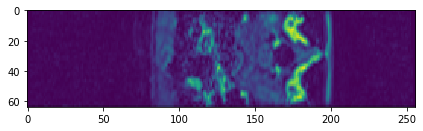

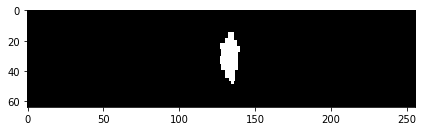

In [ ]:
image_x = random.randint(0, len(images_train)-1)
imshow(X_train[image_x])
plt.show()

imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint


IMG_WIDTH = 256
IMG_HEIGHT = 64
IMG_CHANNELS = 3


def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
  
def get_unet():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [ ]:
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
model = get_unet()

In [ ]:
print('*'*40)
print('Fitting Model')
print('*'*40)
history  = model.fit(X_train, Y_train, batch_size=32, epochs=100, shuffle=True,validation_split=0.1,callbacks=[checkpointer])

****************************************
Fitting Model
****************************************
Epoch 1/100
108/108 [==============================] - ETA: 0s - loss: 0.1232 - dice_coef: 0.0979WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0032s vs `on_test_batch_end` time: 0.0337s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.03449, saving model to model.h5
108/108 [==============================] - 16s 152ms/step - loss: 0.1232 - dice_coef: 0.0979 - val_loss: 0.0345 - val_dice_coef: 0.0888
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 0.0236 - dice_coef: 0.2274
Epoch 00002: val_loss improved from 0.03449 to 0.01566, saving model to model.h5
108/108 [==============================] - 16s 149ms/step - loss: 0.0236 - dice_coef: 0.2274 - val_loss: 0.0157 - val_dice_coef: 0.2140
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 0.0170 - dice_coef: 0.2869
Epoch 0

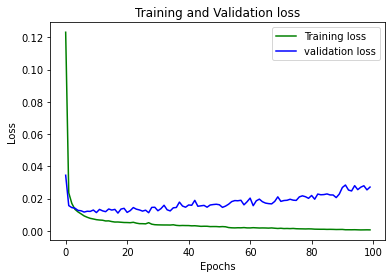

In [ ]:
#loss plot
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
pyplot.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
pyplot.legend()
pyplot.show()

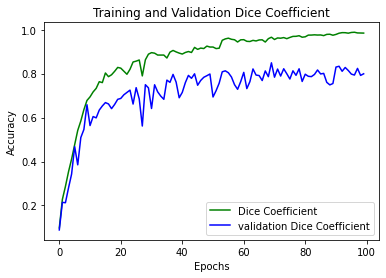

In [ ]:
loss_train = history.history['dice_coef']
loss_val = history.history['val_dice_coef']
plt.plot(loss_train, 'g', label='Dice Coefficient')
plt.plot(loss_val, 'b', label='validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

8/8 [==============================] - 0s 38ms/step


In [ ]:

print(preds_train.shape)
print(preds_val.shape)
print(preds_test.shape)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

print(preds_train_t.shape)
print(preds_val_t.shape)
print(preds_test_t.shape)

(3456, 64, 256, 1)
(384, 64, 256, 1)
(256, 64, 256, 1)
(3456, 64, 256, 1)
(384, 64, 256, 1)
(256, 64, 256, 1)


In [ ]:
# Perform a sanity check on some random training samples
f = 0 
for f in range(1,100):
  ix_train = random.randint(0, len(preds_train_t)-1)
  print(ix_train)
  imshow(X_train[ix_train])
  plt.show()
  imshow(np.squeeze(Y_train[ix_train]))
  plt.show()
  imshow(np.squeeze(preds_train_t[ix_train]))
  plt.show()

IndentationError: ignored

1


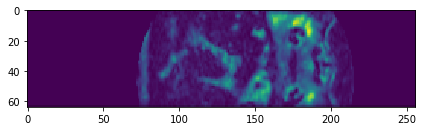

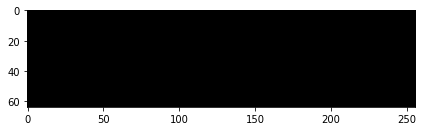

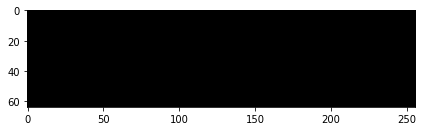

2


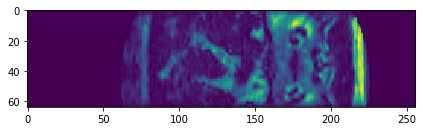

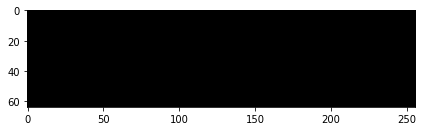

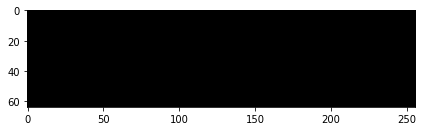

3


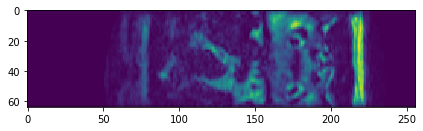

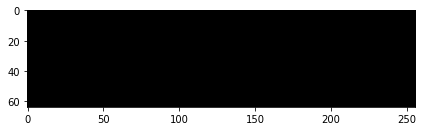

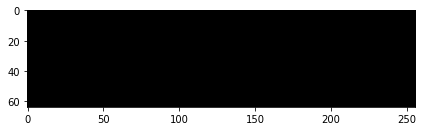

4


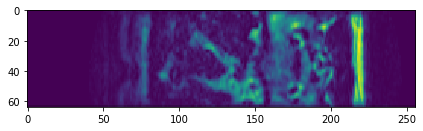

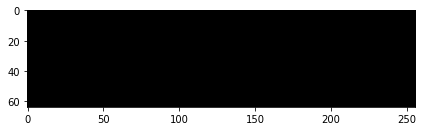

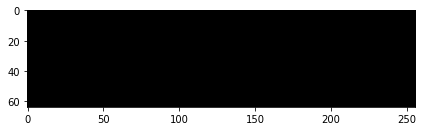

5


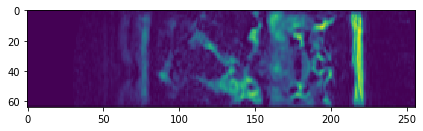

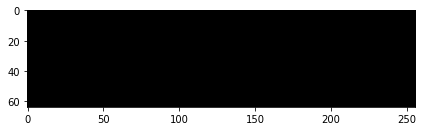

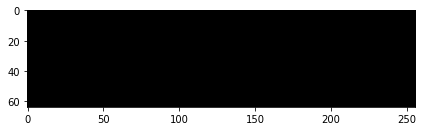

6


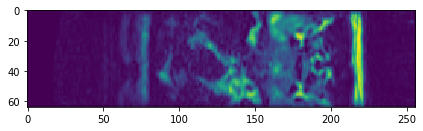

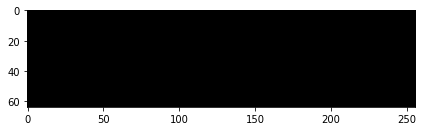

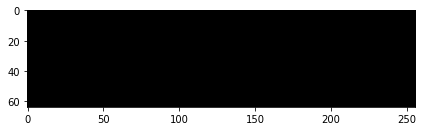

7


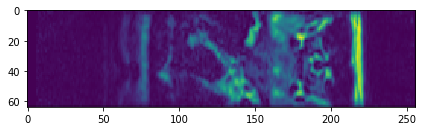

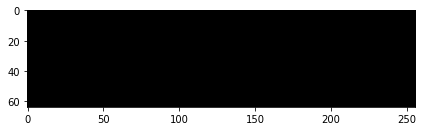

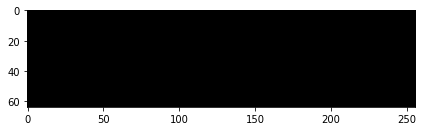

8


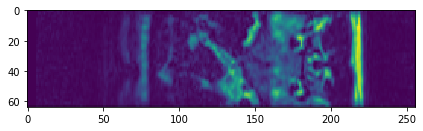

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


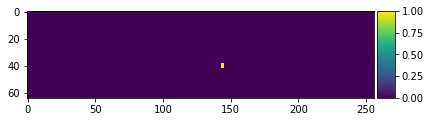

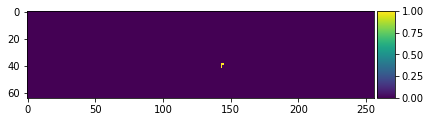

9


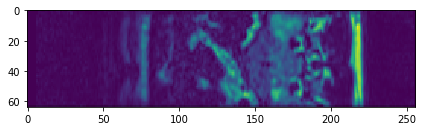

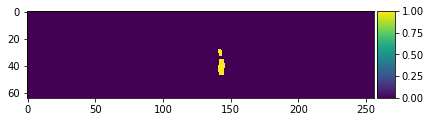

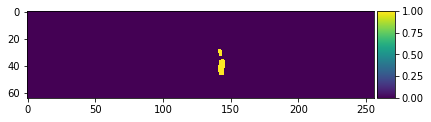

10


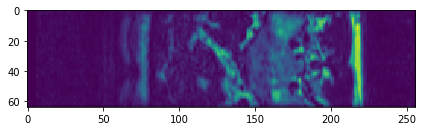

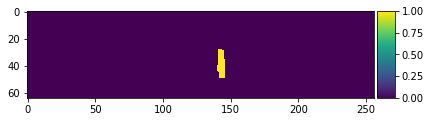

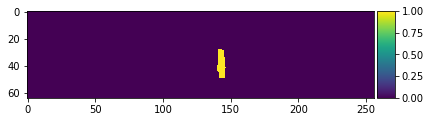

11


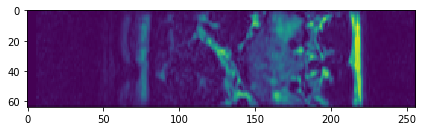

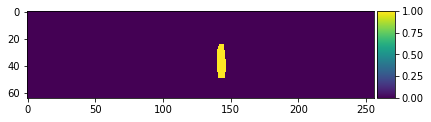

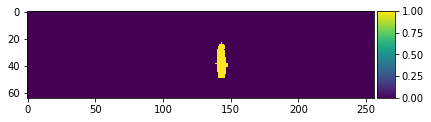

12


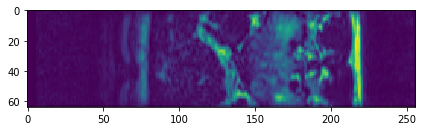

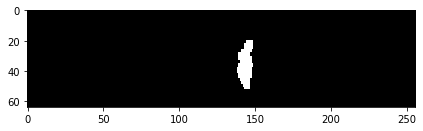

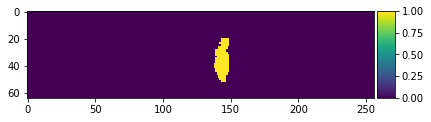

13


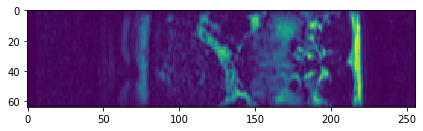

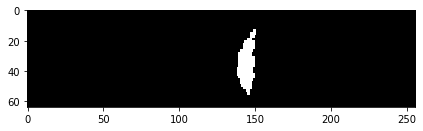

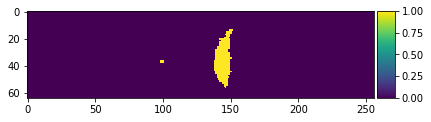

14


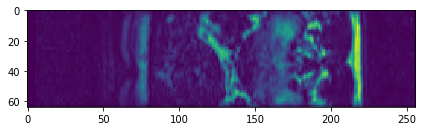

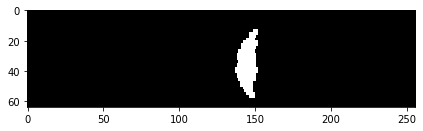

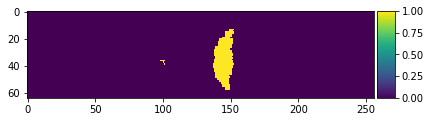

15


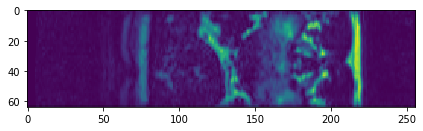

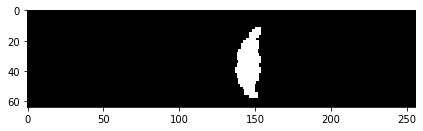

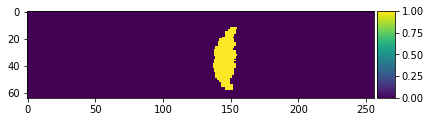

16


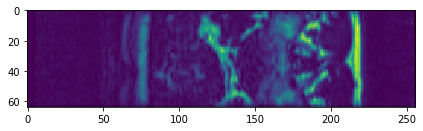

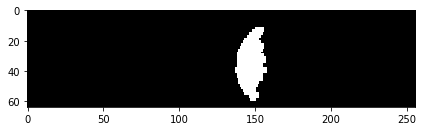

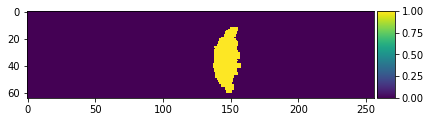

17


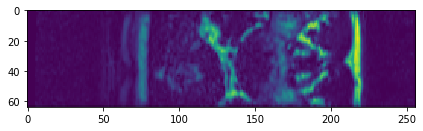

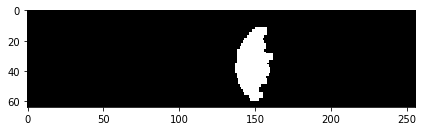

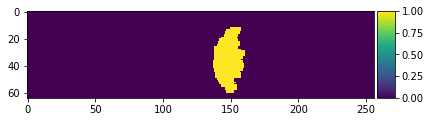

18


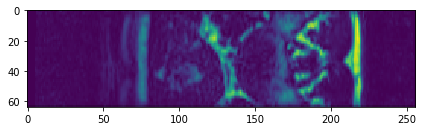

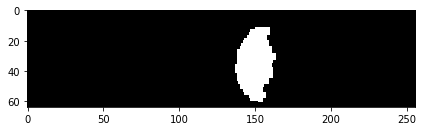

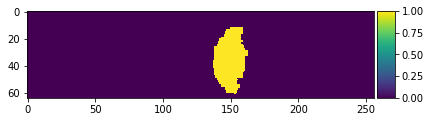

19


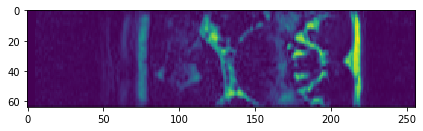

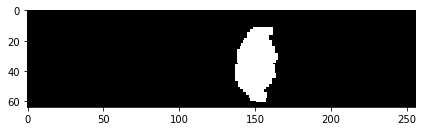

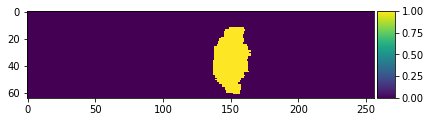

20


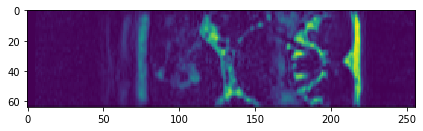

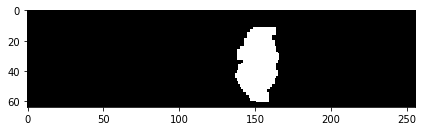

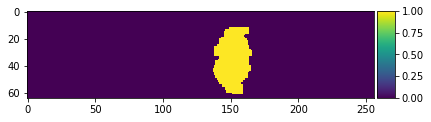

21


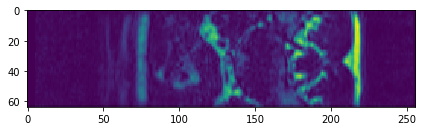

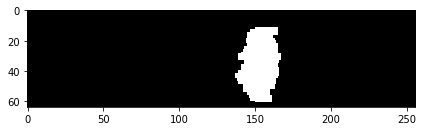

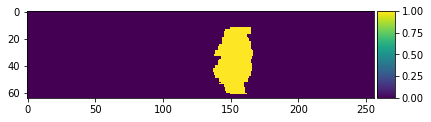

22


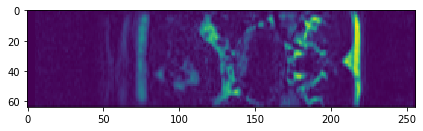

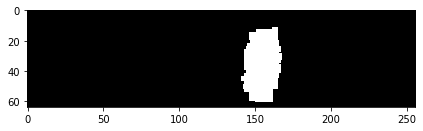

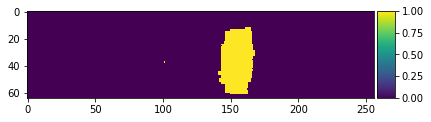

23


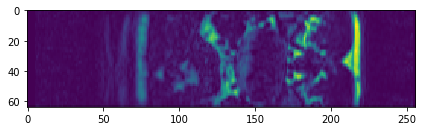

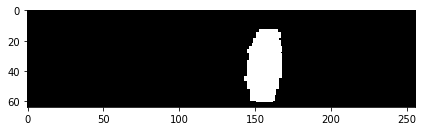

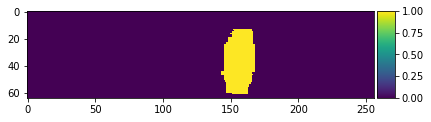

24


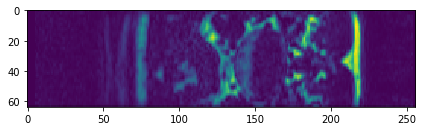

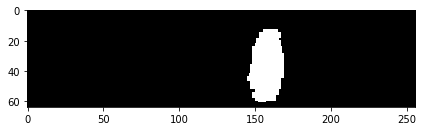

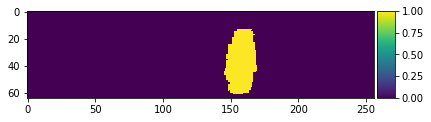

25


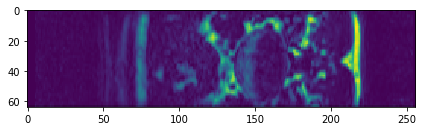

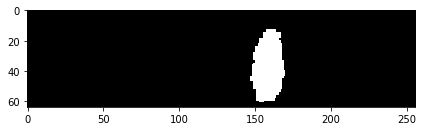

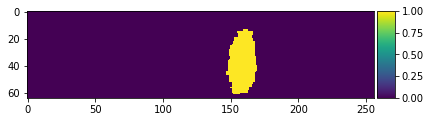

26


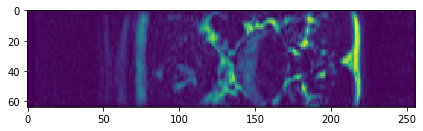

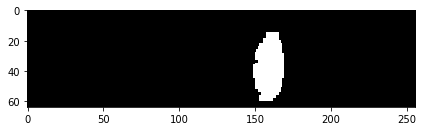

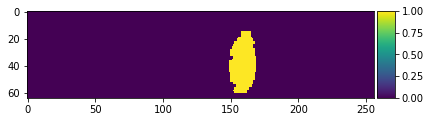

27


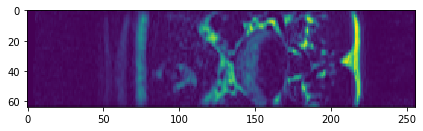

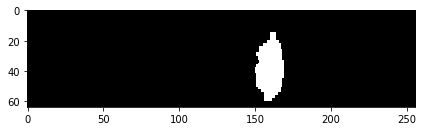

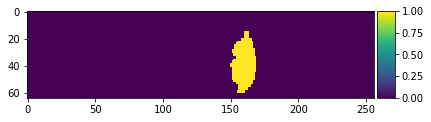

28


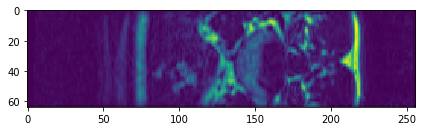

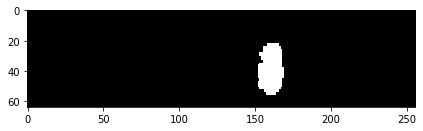

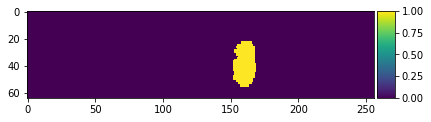

29


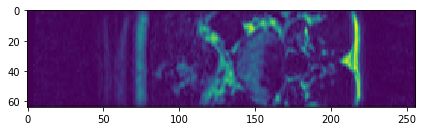

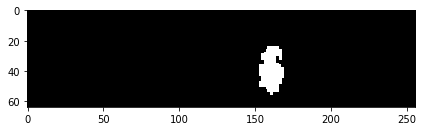

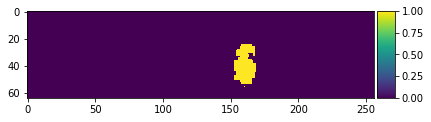

30


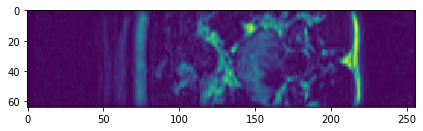

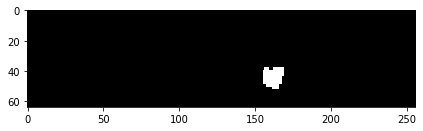

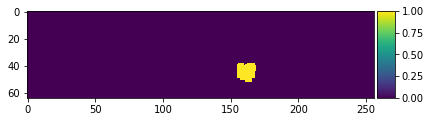

31


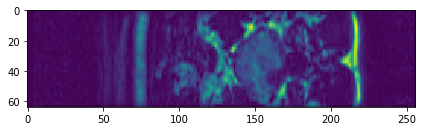

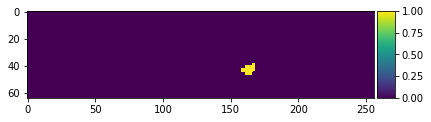

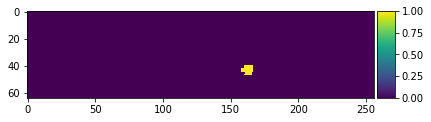

32


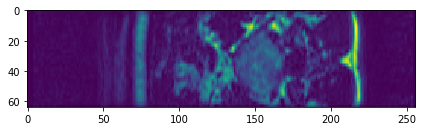

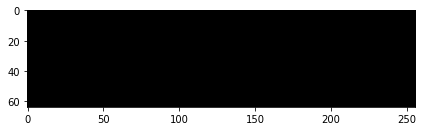

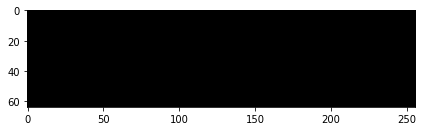

33


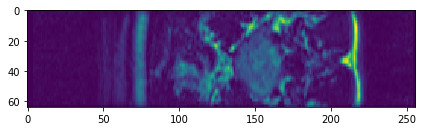

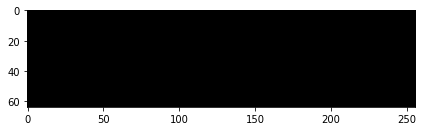

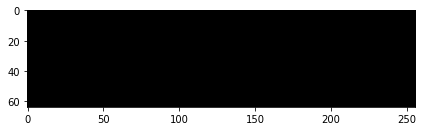

34


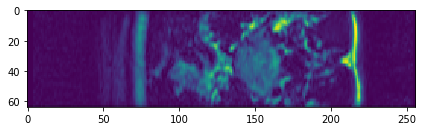

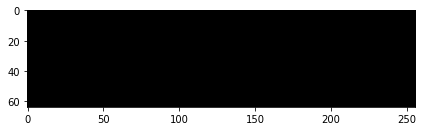

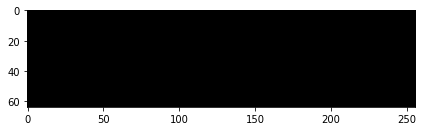

35


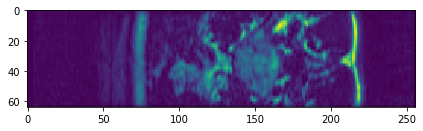

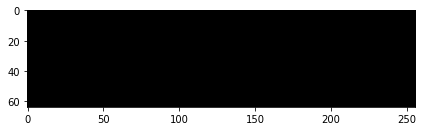

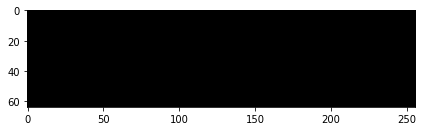

36


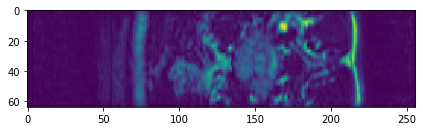

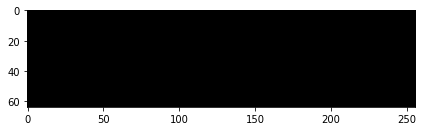

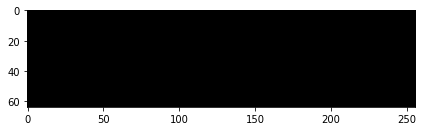

37


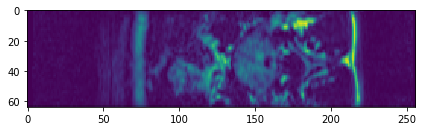

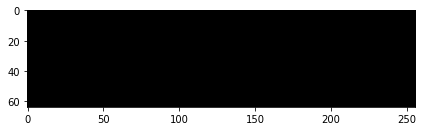

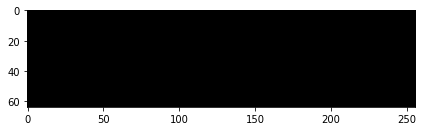

38


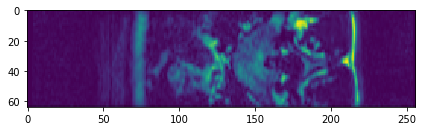

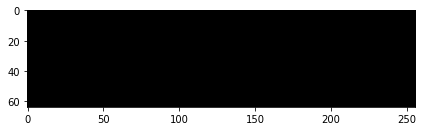

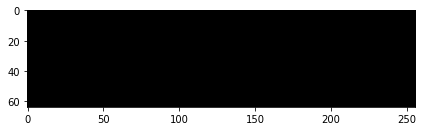

39


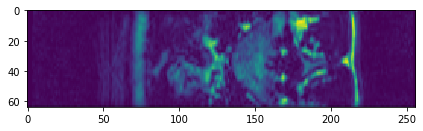

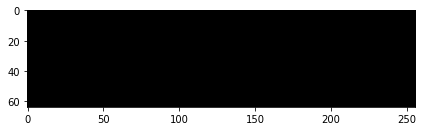

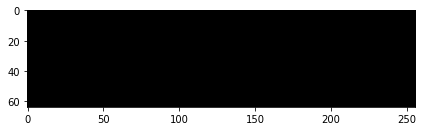

40


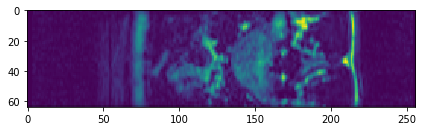

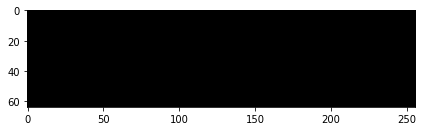

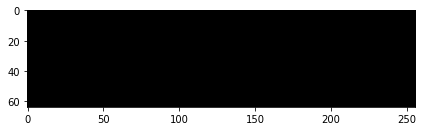

41


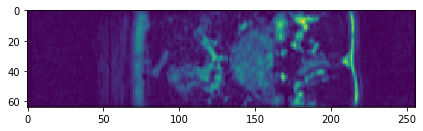

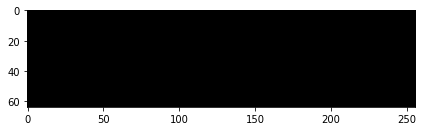

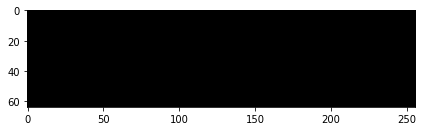

42


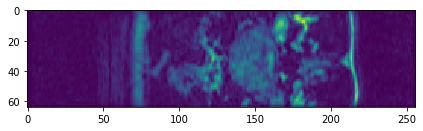

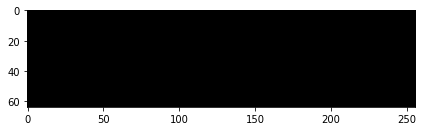

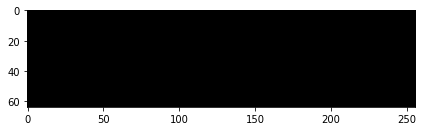

43


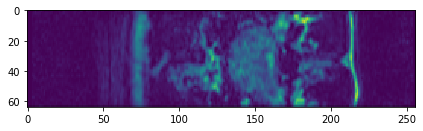

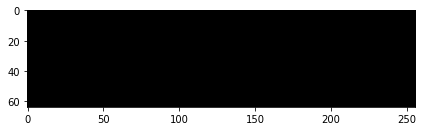

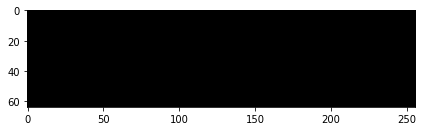

44


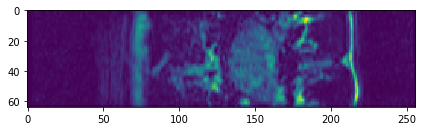

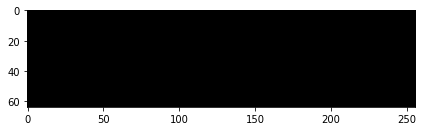

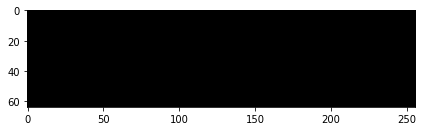

45


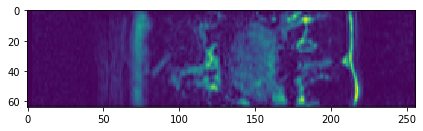

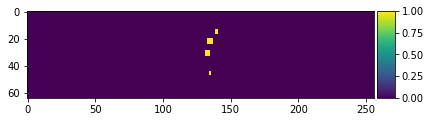

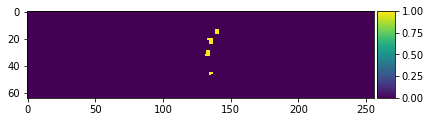

46


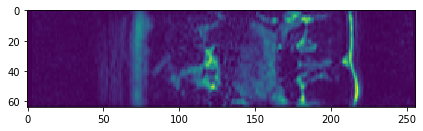

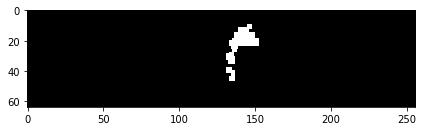

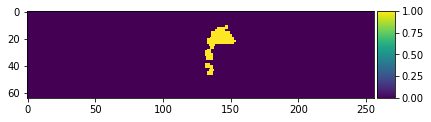

47


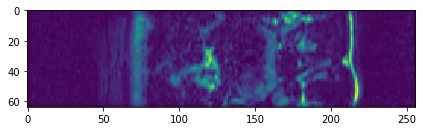

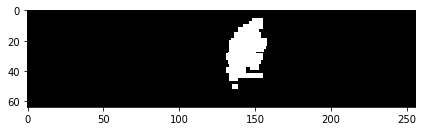

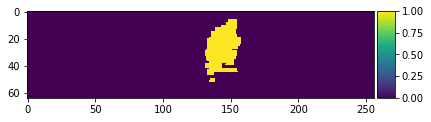

48


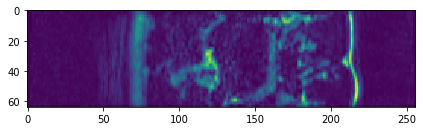

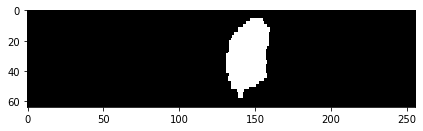

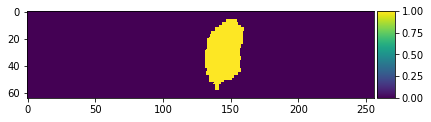

49


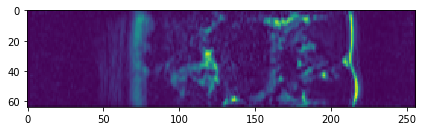

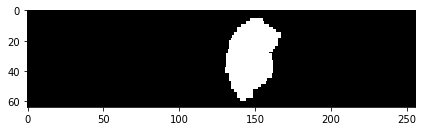

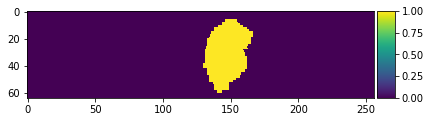

In [ ]:
#ix_train = random.randint(0, len(preds_train_t)-1)
n = 0
for n in range(1,50):
  ix_train = n
  print(ix_train)
  imshow(X_train[ix_train])
  plt.show()
  imshow(np.squeeze(Y_train[ix_train]))
  plt.show()
  imshow(np.squeeze(preds_train_t[ix_train]))
  plt.show()
  

16


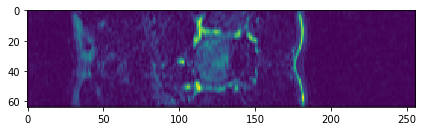

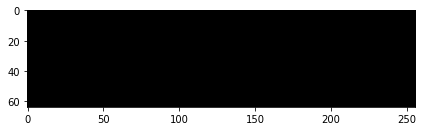

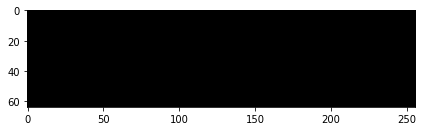

368


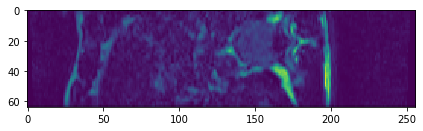

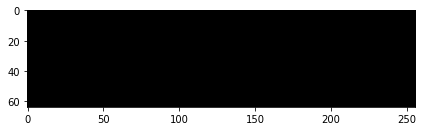

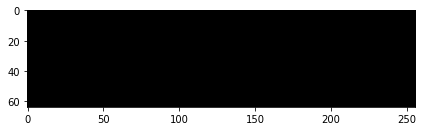

324


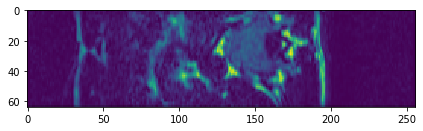

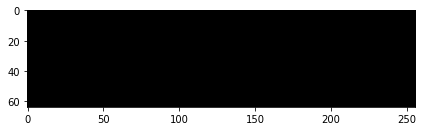

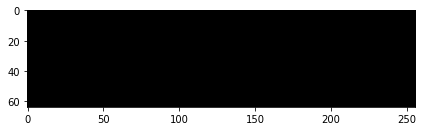

367


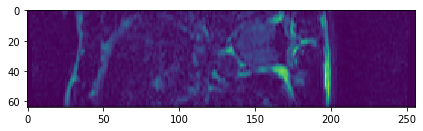

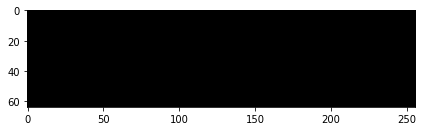

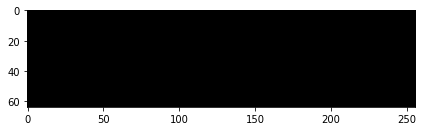

140


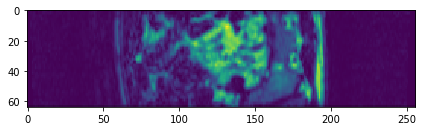

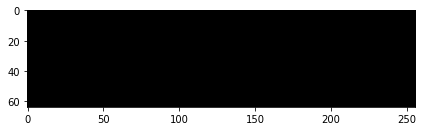

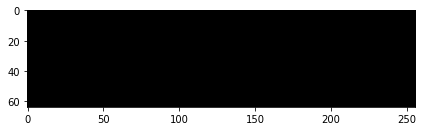

310


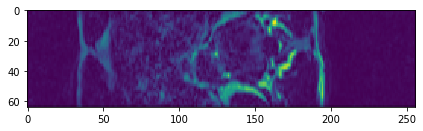

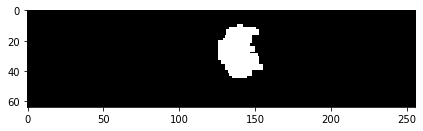

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


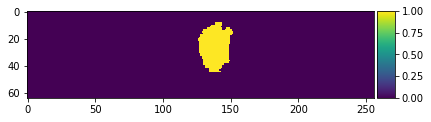

198


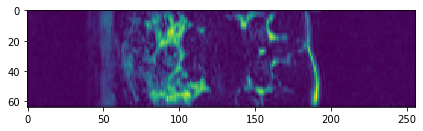

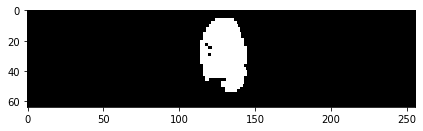

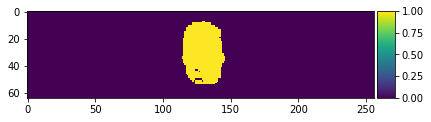

55


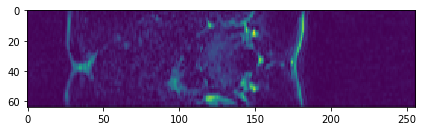

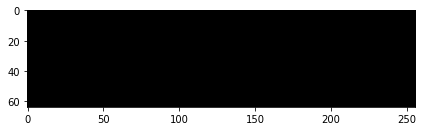

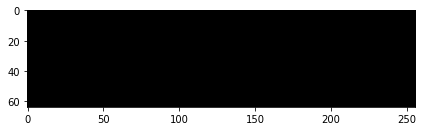

133


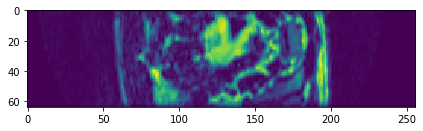

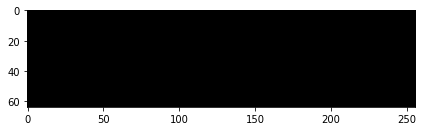

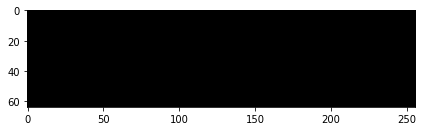

22


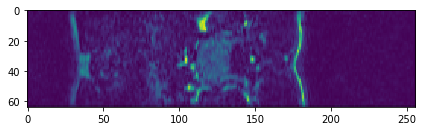

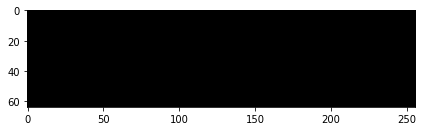

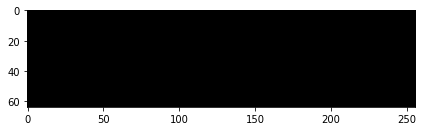

313


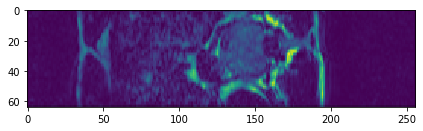

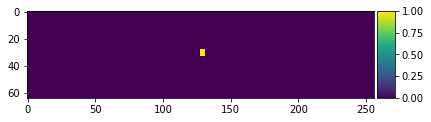

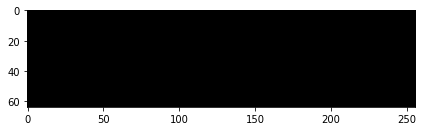

138


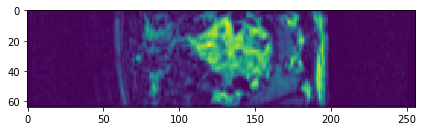

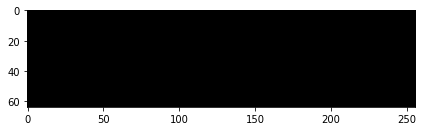

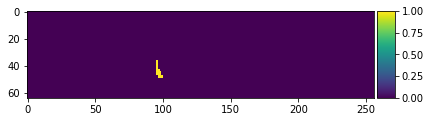

157


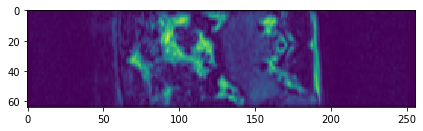

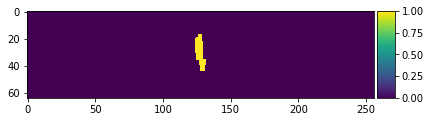

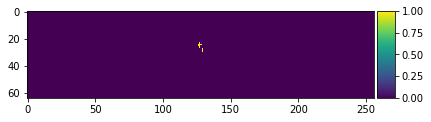

340


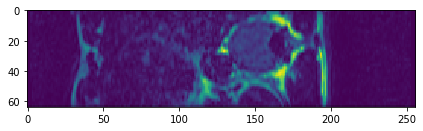

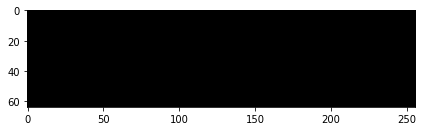

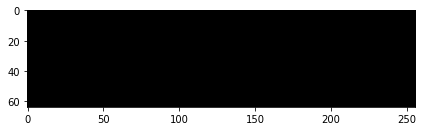

245


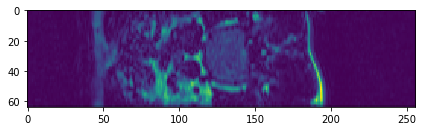

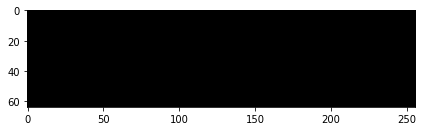

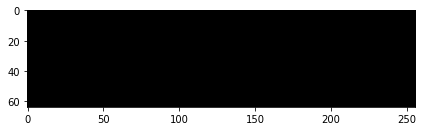

313


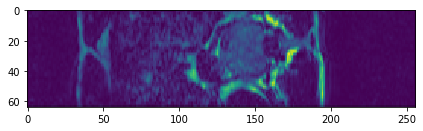

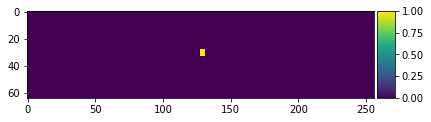

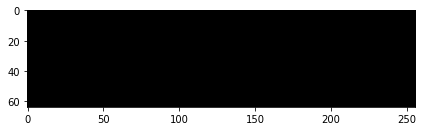

16


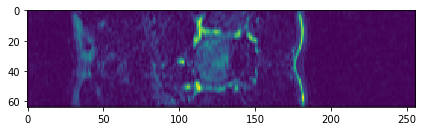

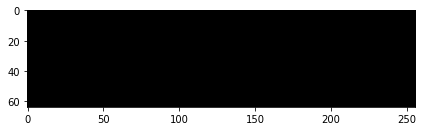

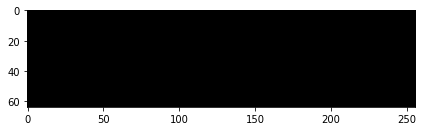

172


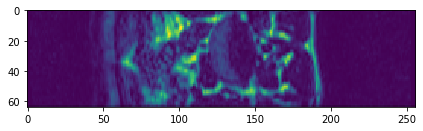

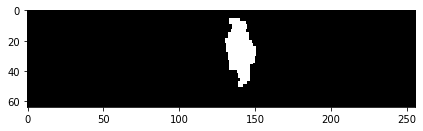

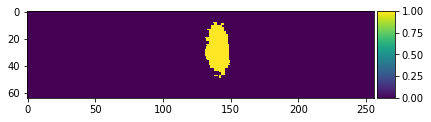

328


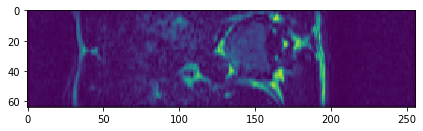

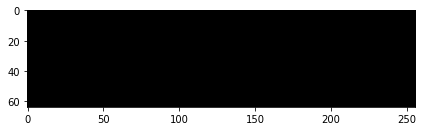

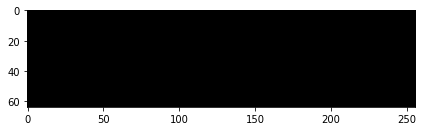

334


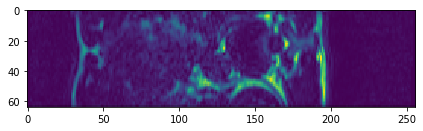

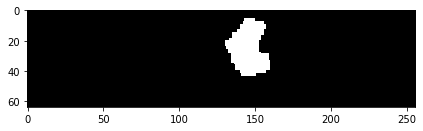

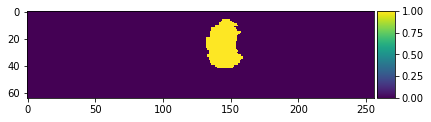

353


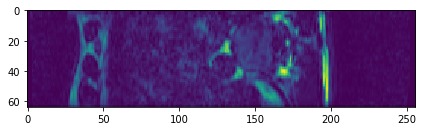

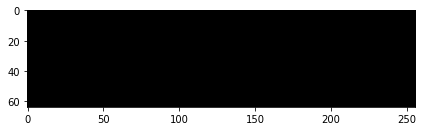

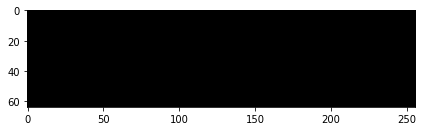

92


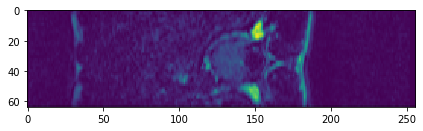

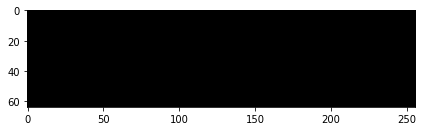

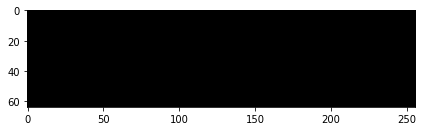

261


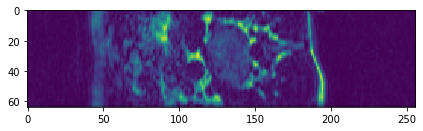

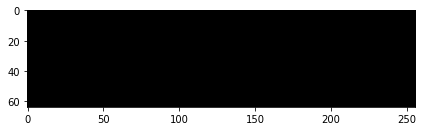

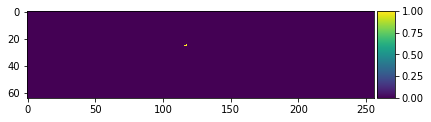

8


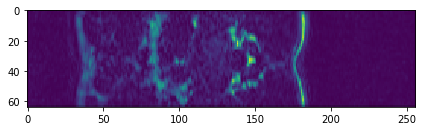

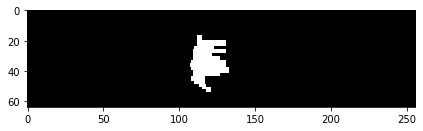

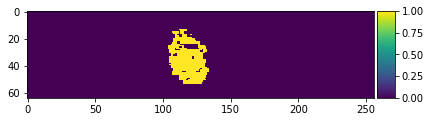

70


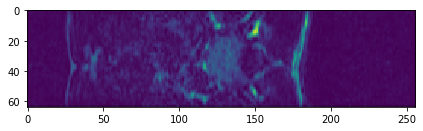

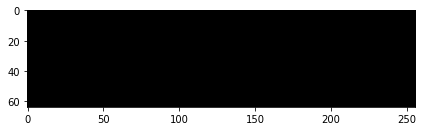

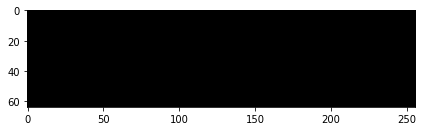

36


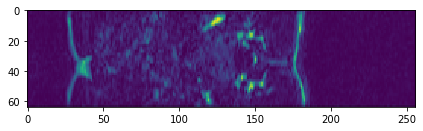

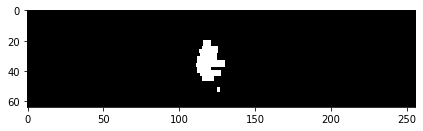

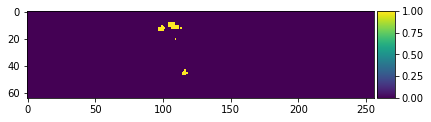

154


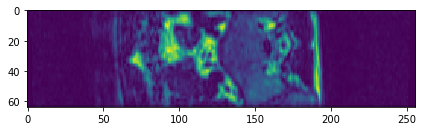

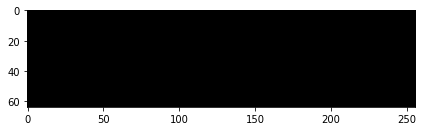

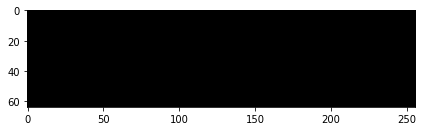

88


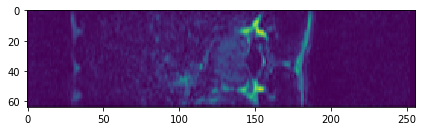

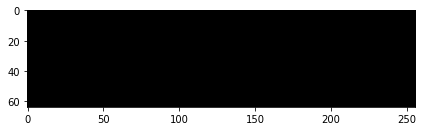

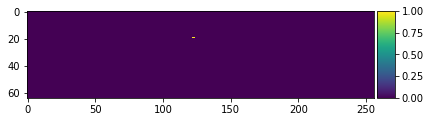

33


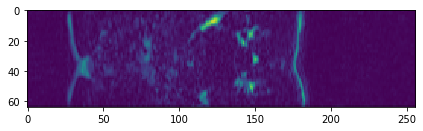

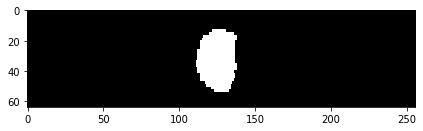

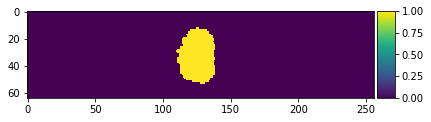

273


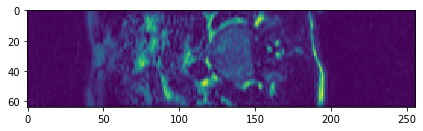

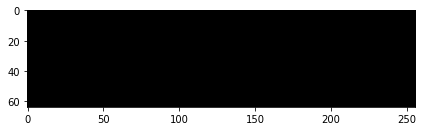

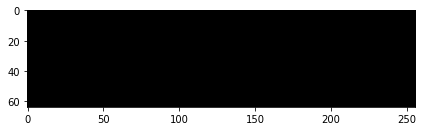

16


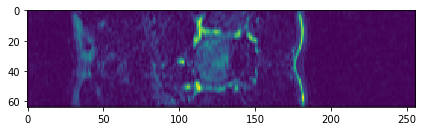

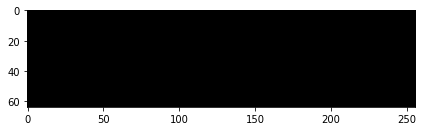

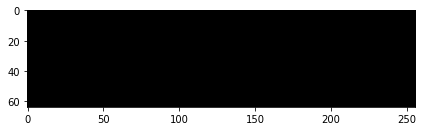

355


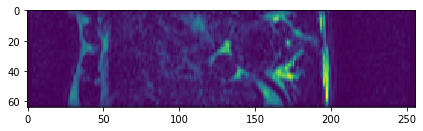

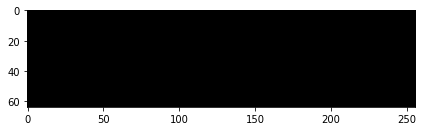

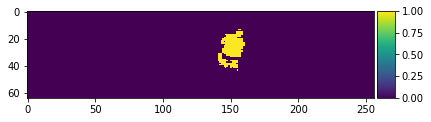

227


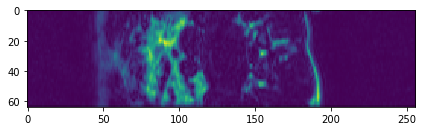

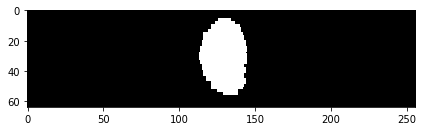

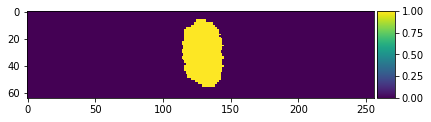

200


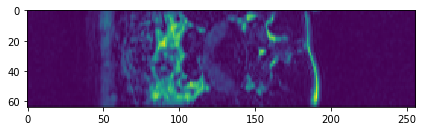

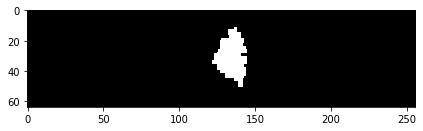

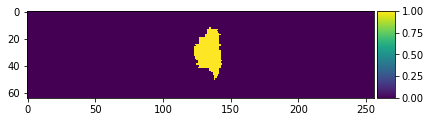

371


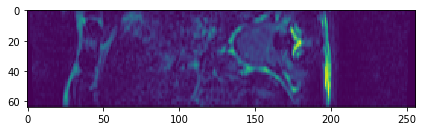

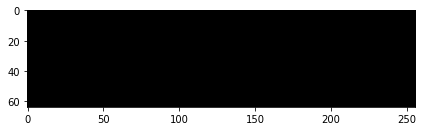

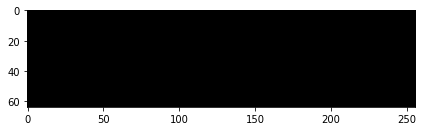

363


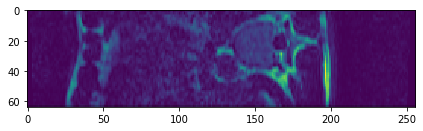

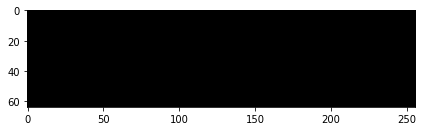

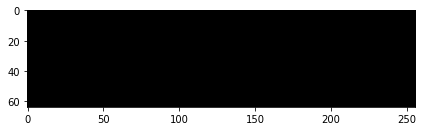

379


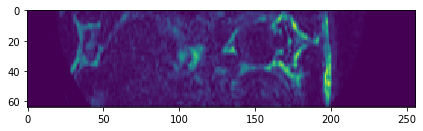

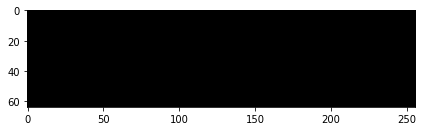

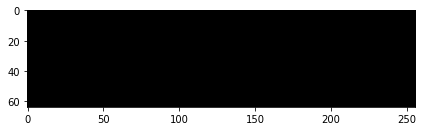

74


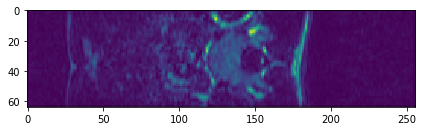

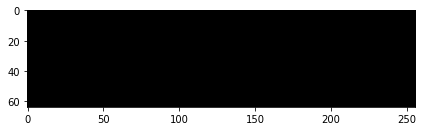

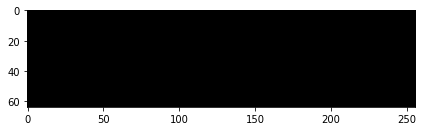

192


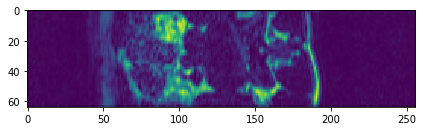

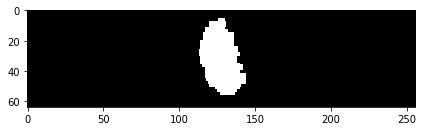

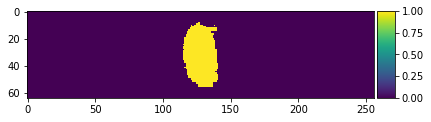

45


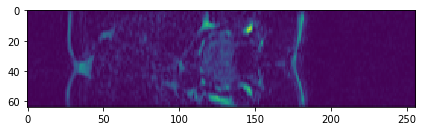

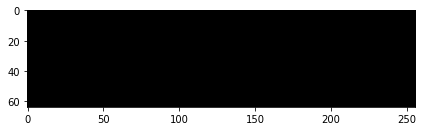

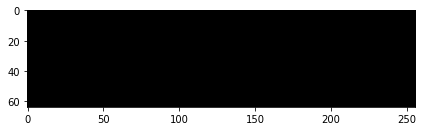

42


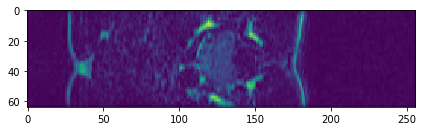

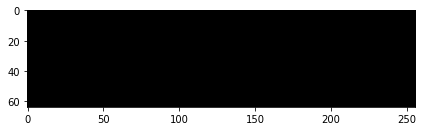

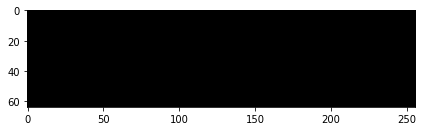

188


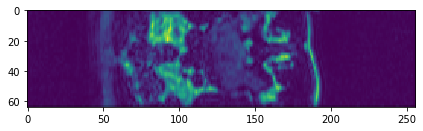

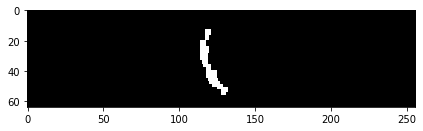

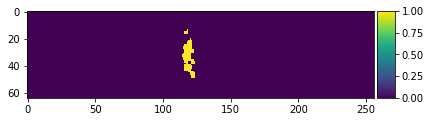

160


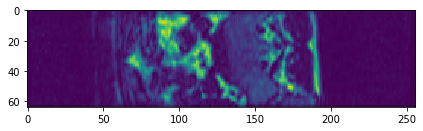

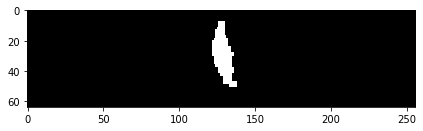

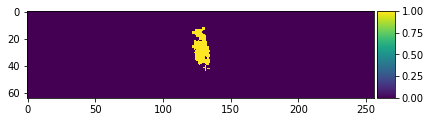

97


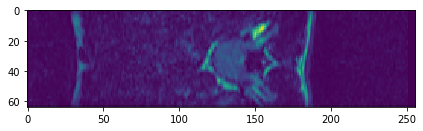

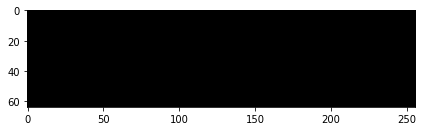

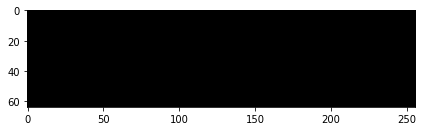

100


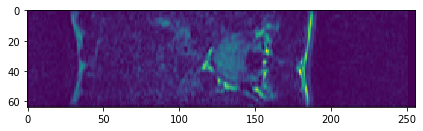

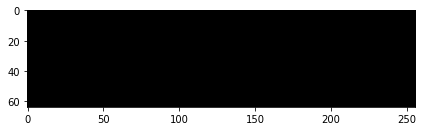

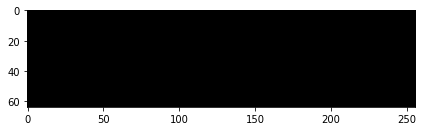

252


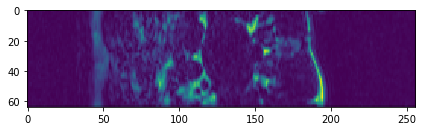

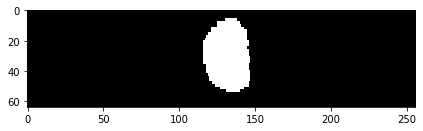

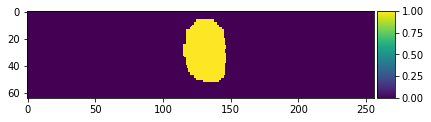

142


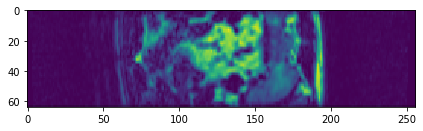

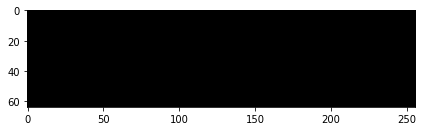

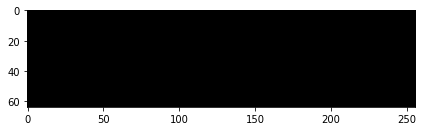

4


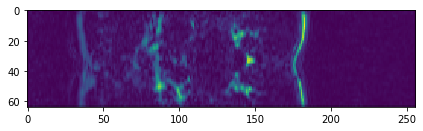

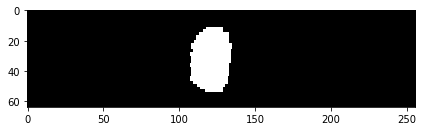

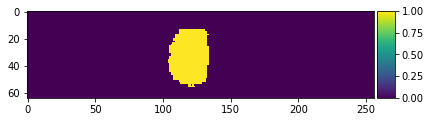

104


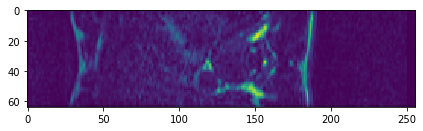

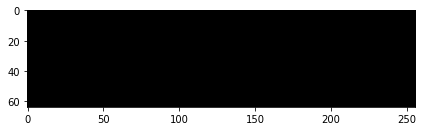

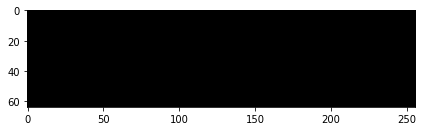

43


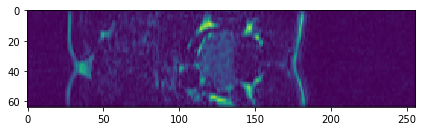

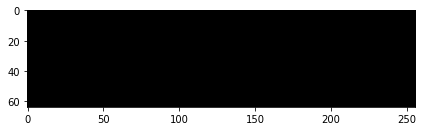

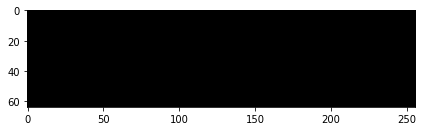

70


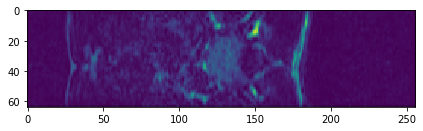

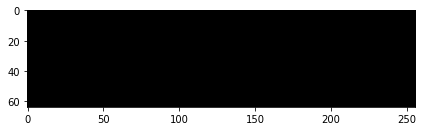

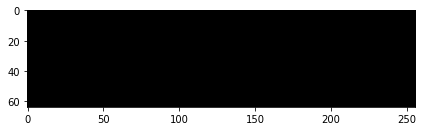

150


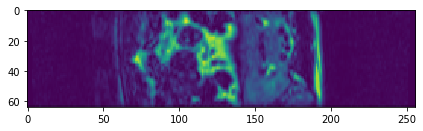

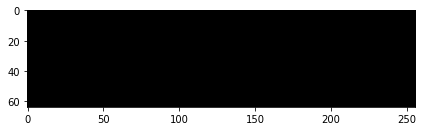

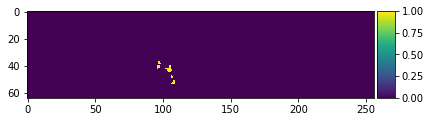

116


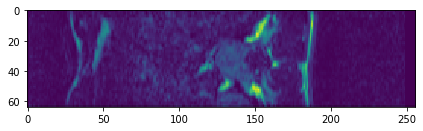

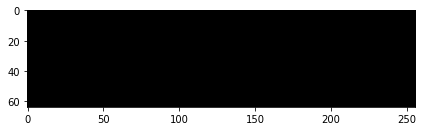

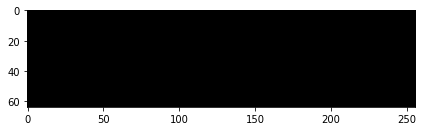

343


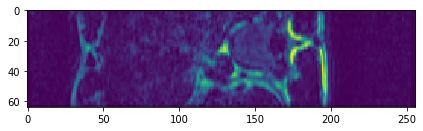

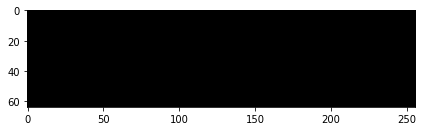

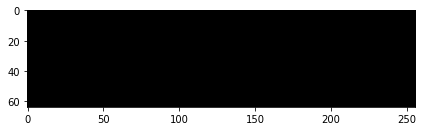

171


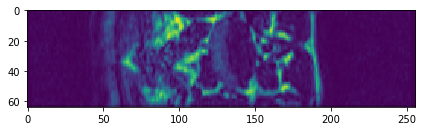

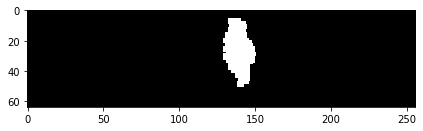

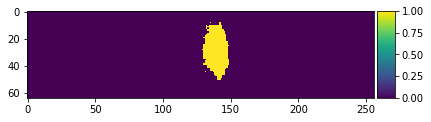

73


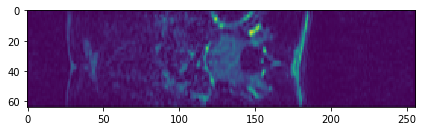

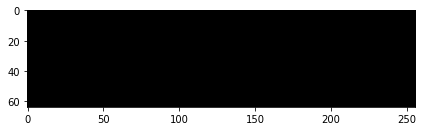

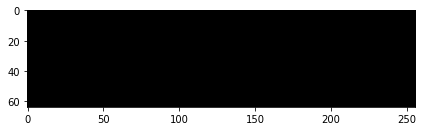

104


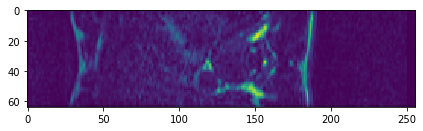

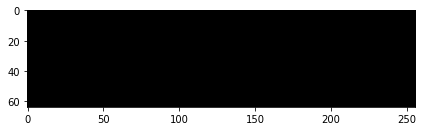

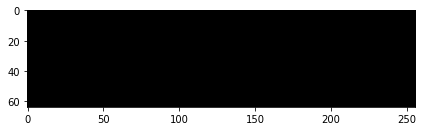

162


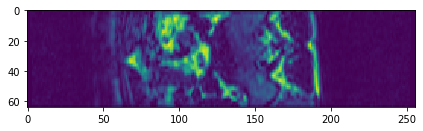

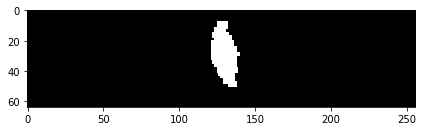

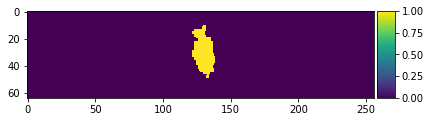

223


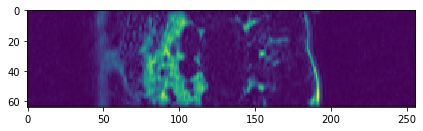

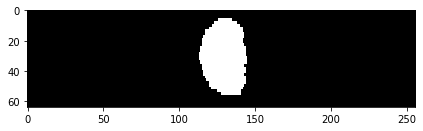

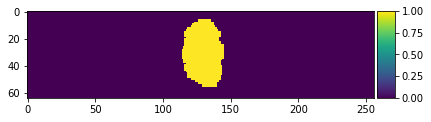

244


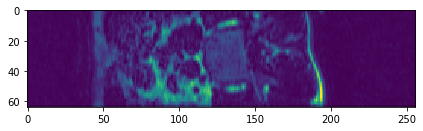

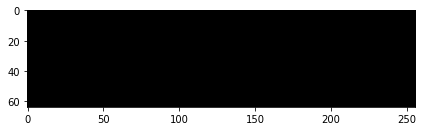

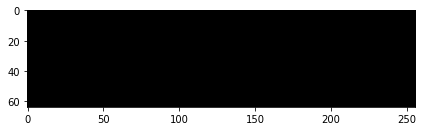

13


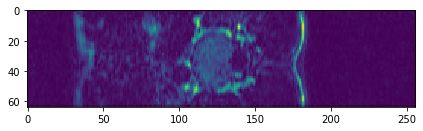

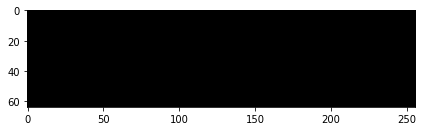

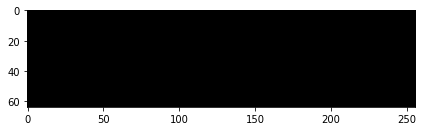

230


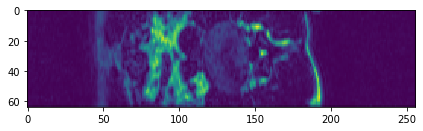

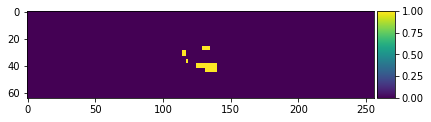

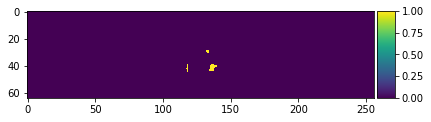

85


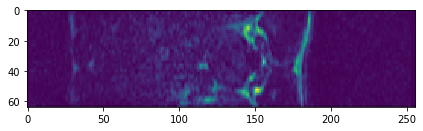

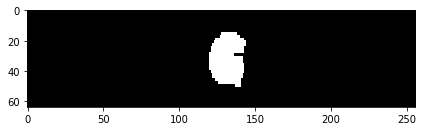

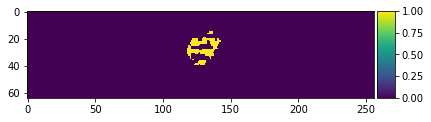

383


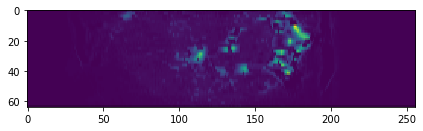

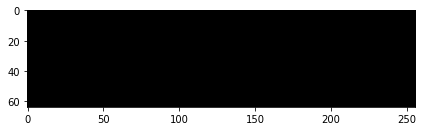

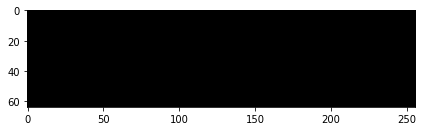

41


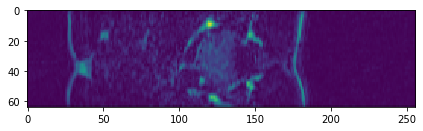

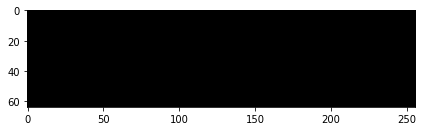

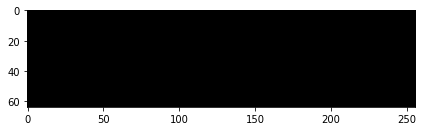

20


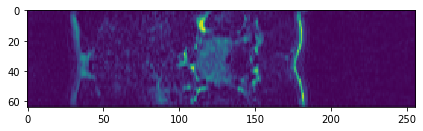

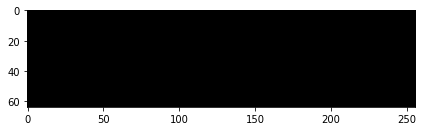

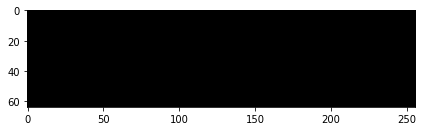

4


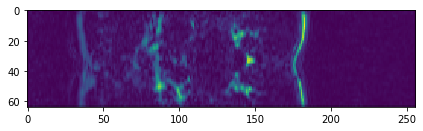

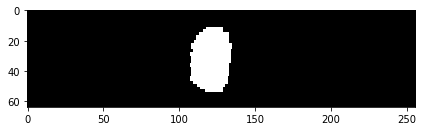

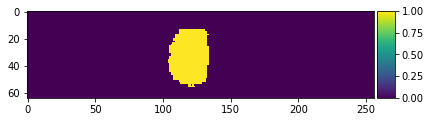

348


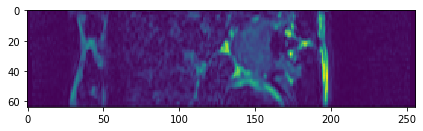

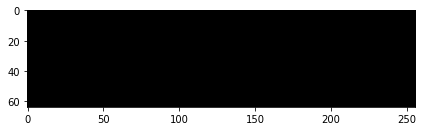

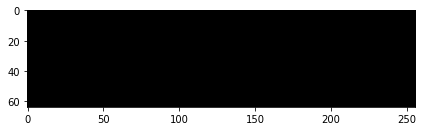

190


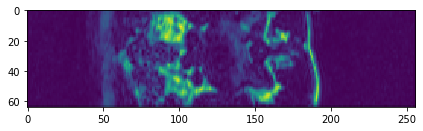

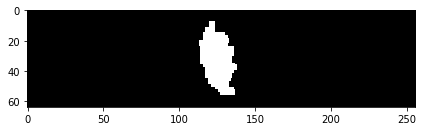

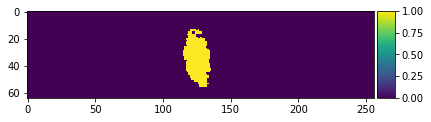

373


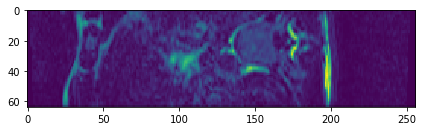

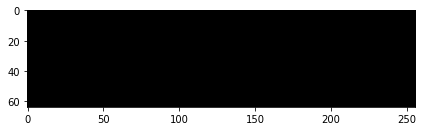

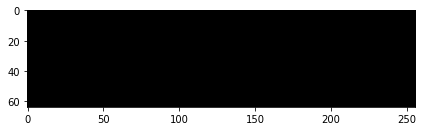

168


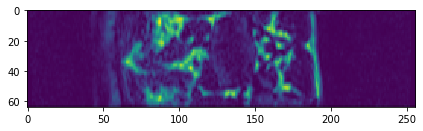

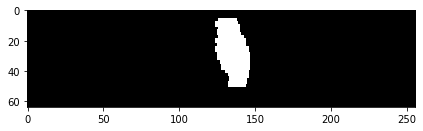

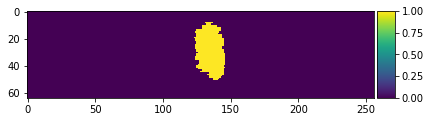

143


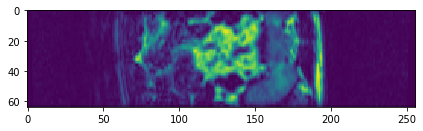

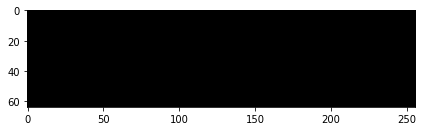

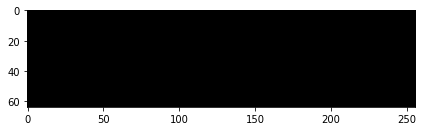

43


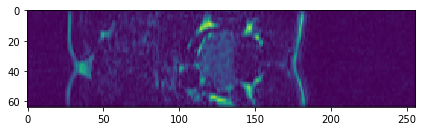

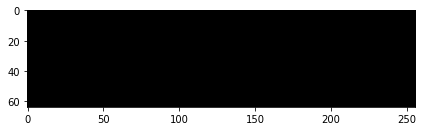

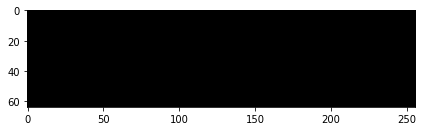

38


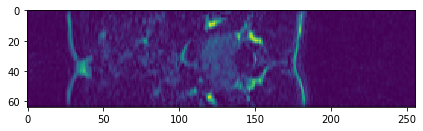

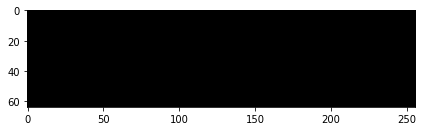

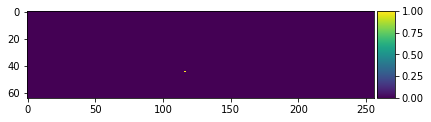

115


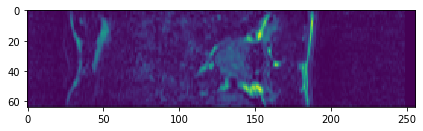

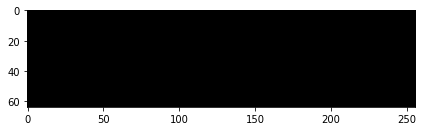

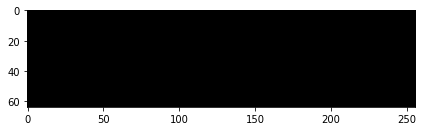

53


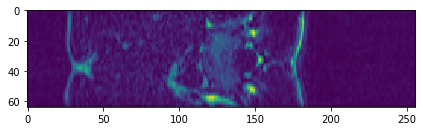

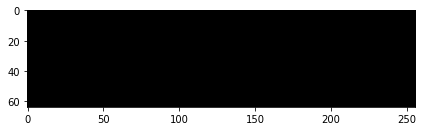

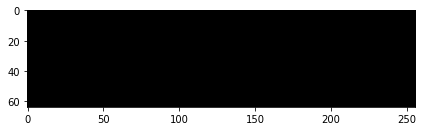

58


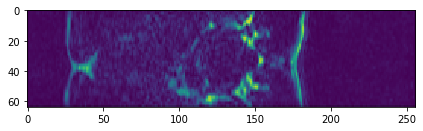

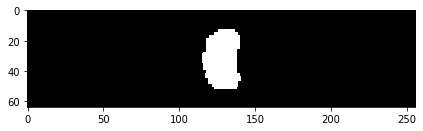

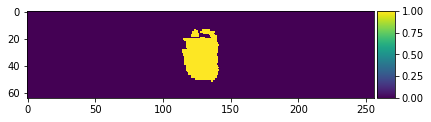

72


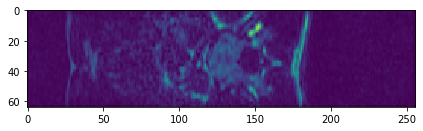

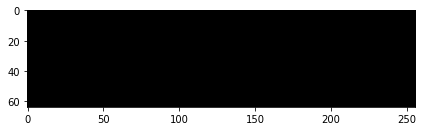

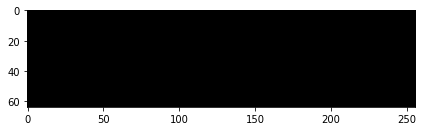

124


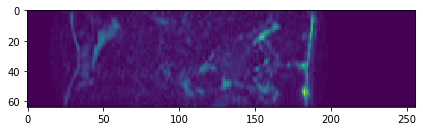

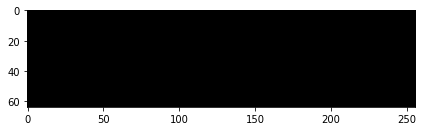

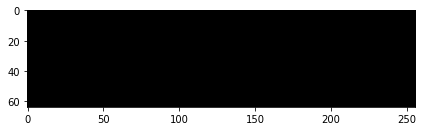

206


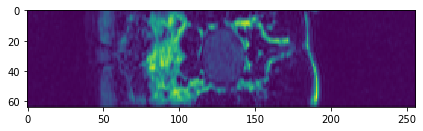

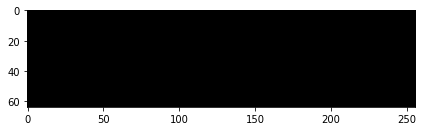

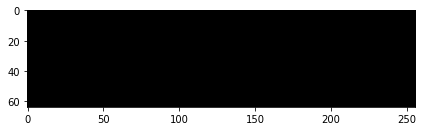

374


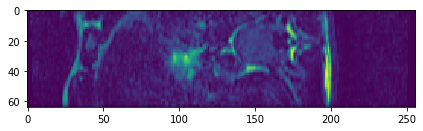

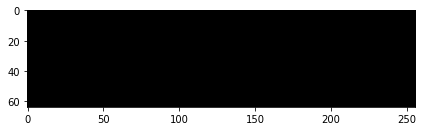

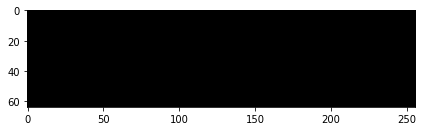

237


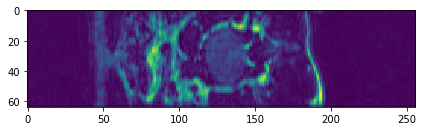

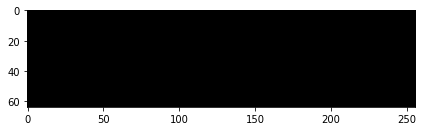

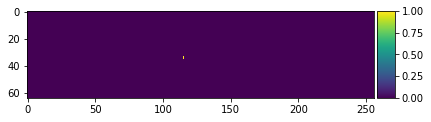

64


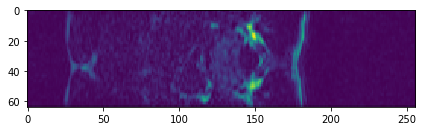

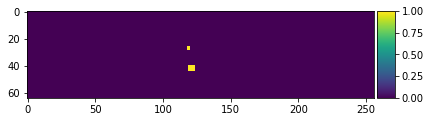

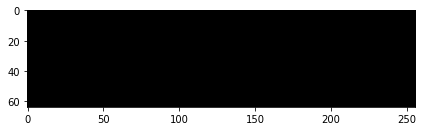

354


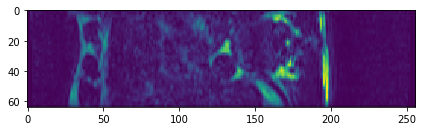

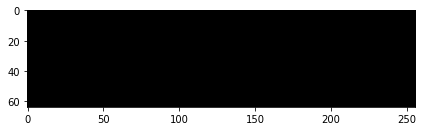

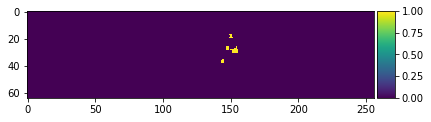

121


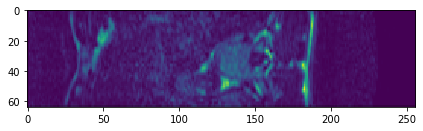

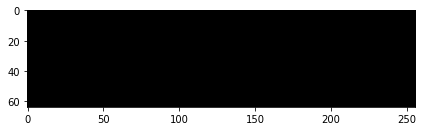

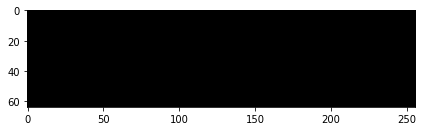

376


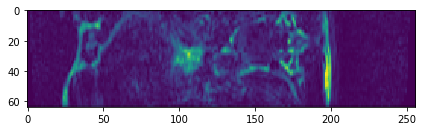

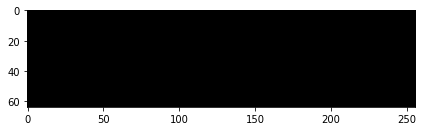

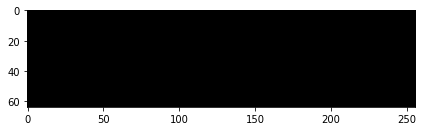

218


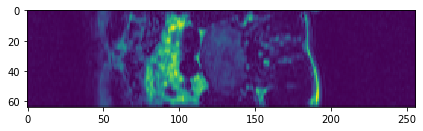

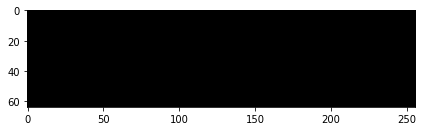

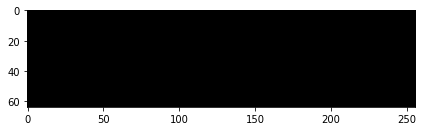

21


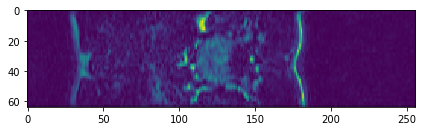

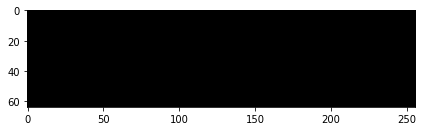

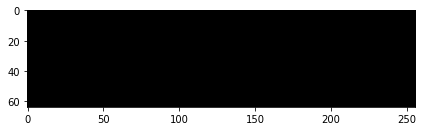

317


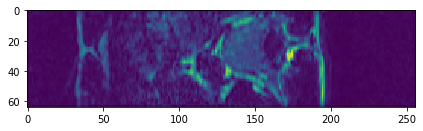

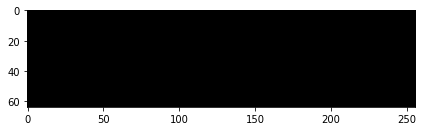

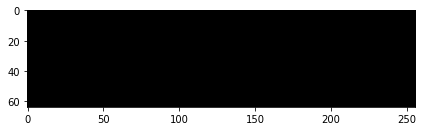

61


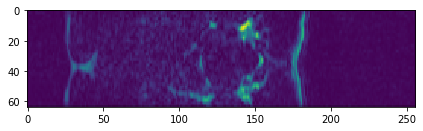

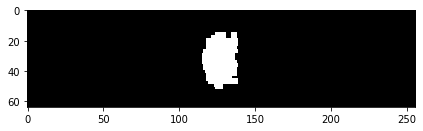

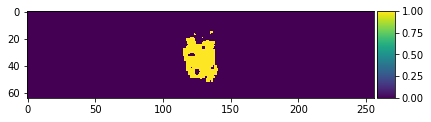

173


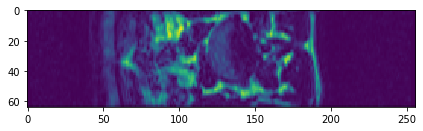

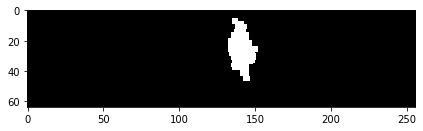

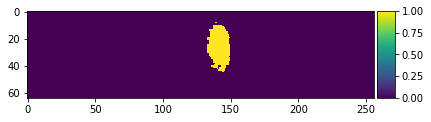

121


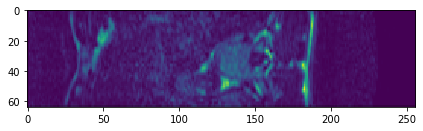

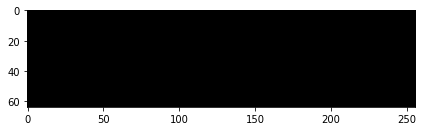

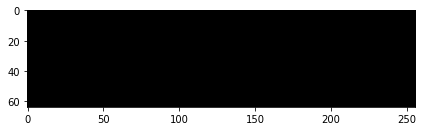

27


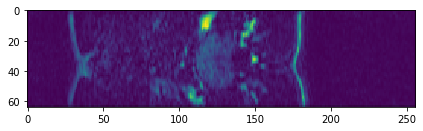

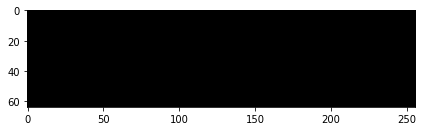

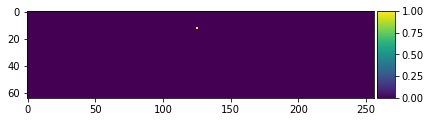

333


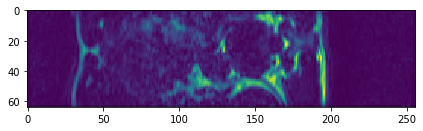

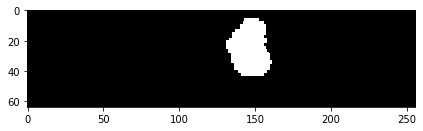

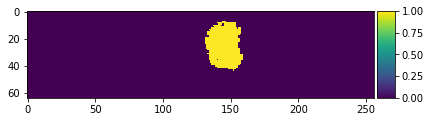

366


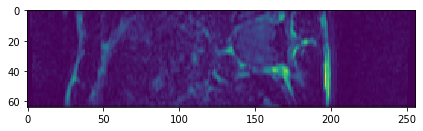

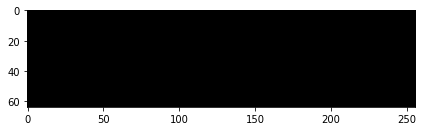

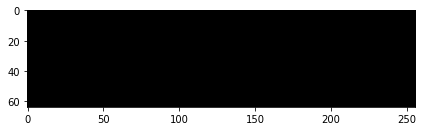

381


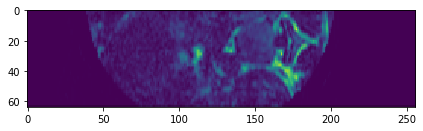

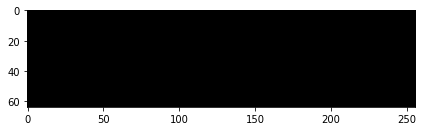

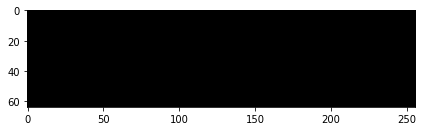

252


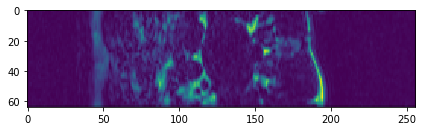

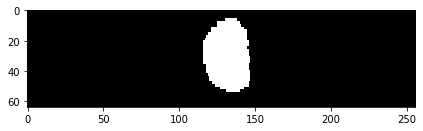

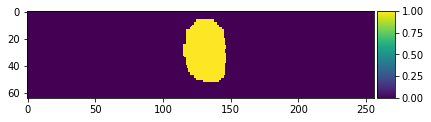

89


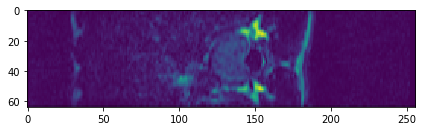

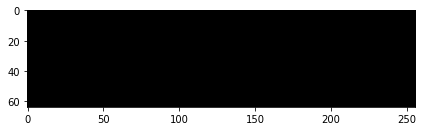

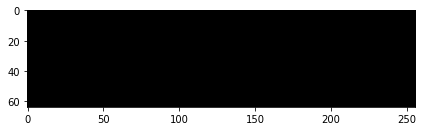

244


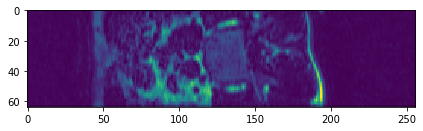

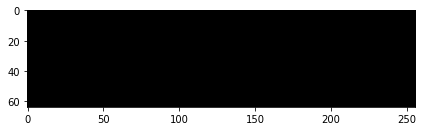

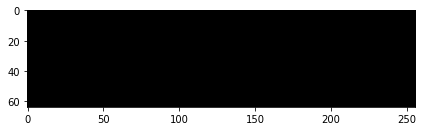

In [ ]:
# Perform a sanity check on some random validation samples
i = 0 
for i in range(1,100):
  ix_val = random.randint(0, len(preds_val_t)-1)
  print(ix_val)
  imshow(X_train[int(X_train.shape[0]*0.9):][ix_val])
  plt.show()
  imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix_val]))
  plt.show()
  imshow(np.squeeze(preds_val_t[ix_val]))
  plt.show()
  i+=1
